In [1]:
import numpy as np
import qutip
import matplotlib.pyplot as plt

In [2]:
# Define the collapse operators (Lindblad operators)
num_levels = 6
num_t = 1000
sigma = 96e-9
d_num, A_num = 40, 50
d_interval, A_interval = 2 * np.pi * 10000e6, 500e6
center_detuning = 2 * np.pi * 0.31092e9

In [3]:
def omega(t, args):
    return args["O"] * np.sin(np.pi * t / args["sigma"]) * np.heaviside(t, 1) * np.heaviside(args["sigma"] - t, 1)


In [4]:
rho0 = qutip.Qobj(
    np.diag(np.maximum(0, 1 - np.arange(num_levels)))
)
options = qutip.Options()
options.nsteps = 1000
tlist = np.linspace(0, sigma, num_t)
d_range = np.linspace(
    center_detuning - d_interval / 2, 
    center_detuning + d_interval / 2, 
    d_num
)
A_range = np.linspace(0, A_interval, A_num)


In [5]:
tr_probs = []
for n_d, d in enumerate(d_range):
    values = []
    for n_A, A in enumerate(A_range):
        
        # Define the Hamiltonian (you will need to add your own Hamiltonian terms)
        H0 = d * 0.5 * qutip.Qobj(np.diag(np.maximum(0, np.arange(num_levels) - 1) * (np.maximum(0, np.arange(num_levels)))))
        H1 = 0.5 * qutip.Qobj(
            np.diag(np.sqrt(np.arange(num_levels-1) + 1), -1) \
            + np.diag(np.sqrt(np.arange(num_levels-1) + 1), 1) 
        ) 
#         H0 = 0.5 * d * qutip.Qobj([[0,0,0,0,0,0,0,0],
#                                    [0,0,0,0,0,0,0,0],
#                                    [0,0,1,0,0,0,0,0],
#                                    [0,0,0,2,0,0,0,0],
#                                    [0,0,0,0,3,0,0,0],
#                                    [0,0,0,0,0,4,0,0],
#                                    [0,0,0,0,0,0,5,0],
#                                    [0,0,0,0,0,0,0,6]])
#         H1 = 0.5 * qutip.Qobj([[0,1,0,0,0,0,0,0],
#                                [1,0,np.sqrt(2),0,0,0,0,0],
#                                [0,np.sqrt(2),0,np.sqrt(3),0,0,0,0],
#                                [0,0,np.sqrt(3),1/4,np.sqrt(4),0,0,0],
#                                [0,0,0,np.sqrt(4),3/4,np.sqrt(5),0,0],
#                                [0,0,0,0,np.sqrt(5),3/2,np.sqrt(6),0],
#                                [0,0,0,0,0,np.sqrt(6),5/2,np.sqrt(7)],
#                                [0,0,0,0,0,0,np.sqrt(7),15/4],])
        output = qutip.mesolve(
            [
                H0, 
                [H1, omega]
            ],
            rho0=rho0,
            args={"O": A, "sigma": sigma},
            tlist=tlist,
            options=options
        )
        values.append(output.states[-1])
        
    tr_probs.append(values)


In [6]:
tr_probs = np.array(tr_probs)

In [7]:
leakage = np.zeros((d_num, A_num))
for d in range(d_num):
    for A in range(A_num):
        leakage_dA = 0
        for i in range(2,num_levels):
            leakage_dA += np.abs(tr_probs[d][A][i,i])
        leakage[d, A] = leakage_dA


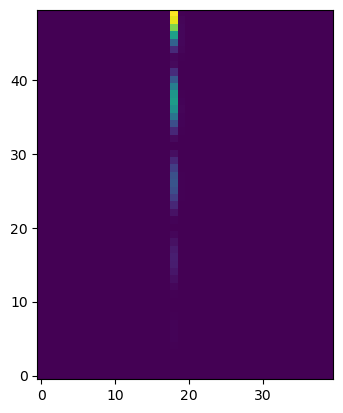

In [8]:
fig1, ax1 = plt.subplots(1,1)
ax1.imshow(leakage.T,origin="lower")

In [9]:
leakage_to_very_high_levels = np.einsum('ijkk', np.abs(tr_probs)[:, :, 3:, 3:])

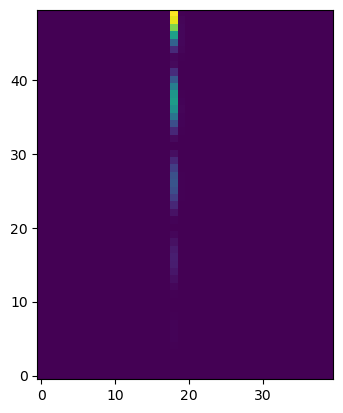

In [10]:
fig3, ax3 = plt.subplots(1,1)
ax3.imshow((leakage - leakage_to_very_high_levels).T,origin="lower")

In [11]:
tr = np.abs(tr_probs[:, :, 1, 1])

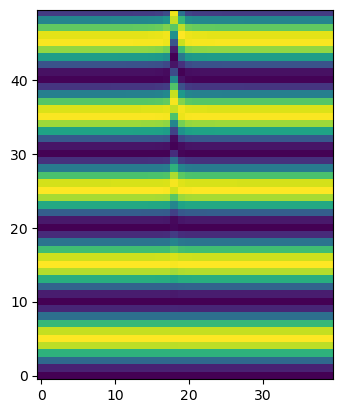

In [12]:
fig2, ax2 = plt.subplots(1,1)
ax2.imshow(tr.T,origin="lower")

In [13]:
print(tr.max())

0.99986200209775
